# Prepare the environment

In [ ]:
#Check NVIDIA GPUs
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4bb2c4f7-1162-168e-0123-5d404c38c4dc)


In [ ]:
import sys
print(f'Python {sys.version}')
print()

import numpy as np
print(f'Numpy {np.__version__}')
print()

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f'Tensorflow {tf.__version__}')
print(f'tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}')

import cv2 as cv
print(f'OpenCV {cv.__version__}')

Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]

Numpy 1.21.5

Tensorflow 2.8.0
tf.keras.backend.image_data_format() = channels_last
OpenCV 4.1.2


In [ ]:
#Count the number of GPUs detected by Tensorglow
gpus = tf.config.list_physical_devices('GPU')
print(f'GPU No. :  {gpus}')
for i, gpu in enumerate(gpus):
  print(f'{i} : Name = {gpu.name}, Type = {gpu.device_type}')

GPU No. :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
0 : Name = /physical_device:GPU:0, Type = GPU


In [ ]:
#Set random seed
np.random.seed(1234)
tf.random.set_seed(5678)

# Load the pretrained model (only feature extractor)

In [ ]:
#Load VGG-16 model
# vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
# vgg_extractor.summary()
InceptionResNetV2_extractor = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
InceptionResNetV2_extractor.summary()

219070464/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)  

# Prepare our dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#0 = mtbike, 1 = tricycle, 2 = tuktuk

x0 = np.load('/content/drive/My Drive/BADS7604/Project/x_mtbike.npy')
x1 = np.load('/content/drive/My Drive/BADS7604/Project/x_tricycle.npy')
x2 = np.load('/content/drive/My Drive/BADS7604/Project/x_tuktuk.npy')

print(x0.shape)
print(x1.shape)
print(x2.shape)

(200, 224, 224, 3)
(200, 224, 224, 3)
(200, 224, 224, 3)


In [ ]:
y0 = []
y1 = []
y2 = []

for i in range(200):
  y0.append(0)
  y1.append(1)
  y2.append(2)

y0 = np.array(y0)
y1 = np.array(y1)
y2 = np.array(y2)

print(y0.shape)
print(y1.shape)
print(y2.shape)

(200,)
(200,)
(200,)


In [ ]:
x = np.concatenate((x0, x1, x2))
y = np.concatenate((y0, y1, y2))
print(x.shape)
print(y.shape)

(600, 224, 224, 3)
(600,)


In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.2
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 3)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(480, 224, 224, 3)
(480,)
(120, 224, 224, 3)
(120,)


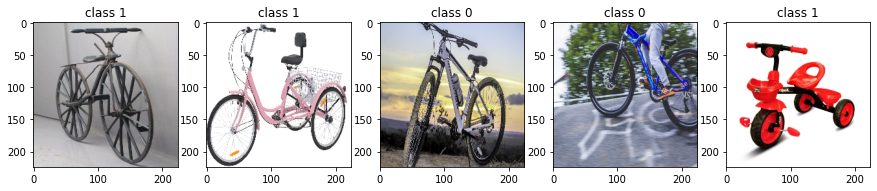

In [ ]:
#visualize the first 5 image
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]}')
  plt.imshow(x_train[i])
plt.show()

In [ ]:
#Pre-processing
x_train_InceptionResNetV2 = tf.keras.applications.inception_resnet_v2.preprocess_input(x_train)
x_test_InceptionResNetV2 = tf.keras.applications.inception_resnet_v2.preprocess_input(x_test)

print(x_train_InceptionResNetV2.shape)
print(x_test_InceptionResNetV2.shape)

(480, 224, 224, 3)
(120, 224, 224, 3)


# Prepare for transfer-learning and fine-tuning

### 1) Freeze layers in model

In [ ]:
#Access a layer by 0-based index
# a = vgg_extractor.layers[3]
a = InceptionResNetV2_extractor.layers[3]
print(f'Layer {a}: Name = {a.name}, Trainable = {a.trainable}')

Layer <keras.layers.core.activation.Activation object at 0x7ff3114f7210>: Name = activation, Trainable = True


In [ ]:
#Access a layer by name
# b = vgg_extractor.get_layer('block5_conv1')
# b = InceptionResNetV2_extractor.get_layer('conv_7b')
b = InceptionResNetV2_extractor.get_layer('block8_10_conv')
print(f'Layer {b}: Name = {b.name}, Trainable = {b.trainable}')

Layer <keras.layers.convolutional.Conv2D object at 0x7ff2952ac250>: Name = block8_10_conv, Trainable = True


In [ ]:
#Iterate over all layers in the model
for i, layer in enumerate(InceptionResNetV2_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = True
Layer 1: Name = conv2d, Trainable = True
Layer 2: Name = batch_normalization, Trainable = True
Layer 3: Name = activation, Trainable = True
Layer 4: Name = conv2d_1, Trainable = True
Layer 5: Name = batch_normalization_1, Trainable = True
Layer 6: Name = activation_1, Trainable = True
Layer 7: Name = conv2d_2, Trainable = True
Layer 8: Name = batch_normalization_2, Trainable = True
Layer 9: Name = activation_2, Trainable = True
Layer 10: Name = max_pooling2d, Trainable = True
Layer 11: Name = conv2d_3, Trainable = True
Layer 12: Name = batch_normalization_3, Trainable = True
Layer 13: Name = activation_3, Trainable = True
Layer 14: Name = conv2d_4, Trainable = True
Layer 15: Name = batch_normalization_4, Trainable = True
Layer 16: Name = activation_4, Trainable = True
Layer 17: Name = max_pooling2d_1, Trainable = True
Layer 18: Name = conv2d_8, Trainable = True
Layer 19: Name = batch_normalization_8, Trainable = True
Layer 20: Name = activation

In [ ]:
#Recursively freeze all layers in the model first
InceptionResNetV2_extractor.trainable = False

for i, layer in enumerate(InceptionResNetV2_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = conv2d, Trainable = False
Layer 2: Name = batch_normalization, Trainable = False
Layer 3: Name = activation, Trainable = False
Layer 4: Name = conv2d_1, Trainable = False
Layer 5: Name = batch_normalization_1, Trainable = False
Layer 6: Name = activation_1, Trainable = False
Layer 7: Name = conv2d_2, Trainable = False
Layer 8: Name = batch_normalization_2, Trainable = False
Layer 9: Name = activation_2, Trainable = False
Layer 10: Name = max_pooling2d, Trainable = False
Layer 11: Name = conv2d_3, Trainable = False
Layer 12: Name = batch_normalization_3, Trainable = False
Layer 13: Name = activation_3, Trainable = False
Layer 14: Name = conv2d_4, Trainable = False
Layer 15: Name = batch_normalization_4, Trainable = False
Layer 16: Name = activation_4, Trainable = False
Layer 17: Name = max_pooling2d_1, Trainable = False
Layer 18: Name = conv2d_8, Trainable = False
Layer 19: Name = batch_normalization_8, Trainable = False
Layer 2

### 2) Add new classification head

In [ ]:
x = InceptionResNetV2_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = InceptionResNetV2_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train the model with transfer-learning

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(x_train_InceptionResNetV2, y_train, batch_size = 128, epochs = 20, verbose = 1, validation_split = 0.2)

Epoch 1/20
3/3 [==============================] - 32s 3s/step - loss: 11.6324 - acc: 0.4479 - val_loss: 13.0717 - val_acc: 0.8333
Epoch 2/20
3/3 [==============================] - 2s 805ms/step - loss: 6.0835 - acc: 0.8906 - val_loss: 3.3388 - val_acc: 0.9271
Epoch 3/20
3/3 [==============================] - 2s 804ms/step - loss: 3.0396 - acc: 0.9141 - val_loss: 0.6088 - val_acc: 0.9688
Epoch 4/20
3/3 [==============================] - 2s 805ms/step - loss: 3.1151 - acc: 0.9401 - val_loss: 0.7308 - val_acc: 0.9896
Epoch 5/20
3/3 [==============================] - 2s 809ms/step - loss: 1.4747 - acc: 0.9792 - val_loss: 2.0735 - val_acc: 0.9479
Epoch 6/20
3/3 [==============================] - 2s 808ms/step - loss: 1.1907 - acc: 0.9844 - val_loss: 5.5292 - val_acc: 0.9271
Epoch 7/20
3/3 [==============================] - 2s 813ms/step - loss: 1.3146 - acc: 0.9766 - val_loss: 4.2796 - val_acc: 0.9167
Epoch 8/20
3/3 [==============================] - 2s 814ms/step - loss: 0.9275 - acc: 0.98

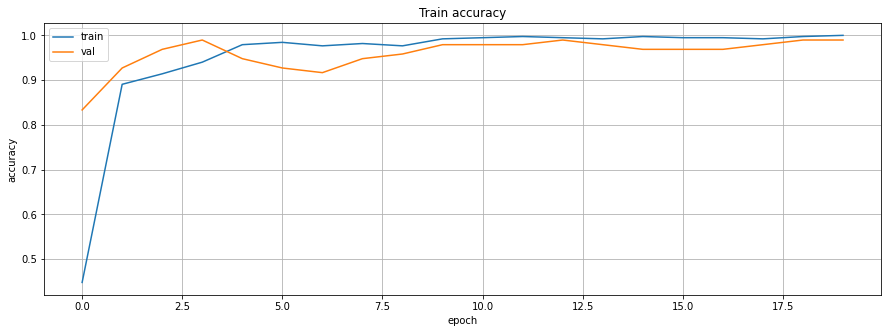

In [ ]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

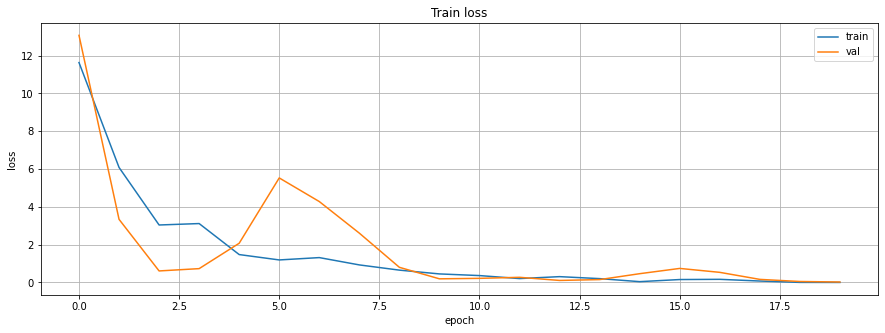

In [ ]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

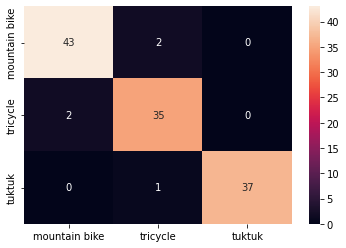

In [ ]:
#Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_name = ['mountain bike', 'tricycle', 'tuktuk']

y_pred = []
for i in range(len(x_test)):
  x_input = x_test_InceptionResNetV2[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, xticklabels = class_name, yticklabels = class_name)

# Evaluate model on test set

In [ ]:
results = model.evaluate(x_test_InceptionResNetV2, y_test, batch_size = 128)
print(f'{model.metrics_names}: {results}')

1/1 [==============================] - 4s 4s/step - loss: 0.9521 - acc: 0.9583
['loss', 'acc']: [0.9520969986915588, 0.9583333134651184]


# Example of prediction

In [ ]:
label = ['mtbike', 'tricycle', 'tuktuk']

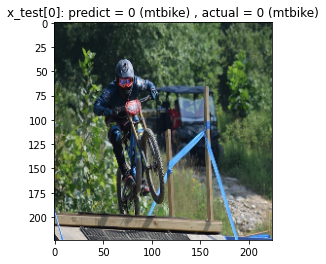

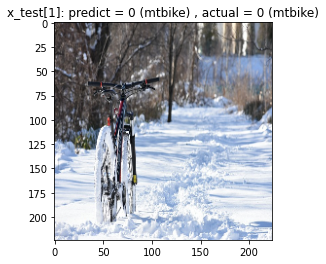

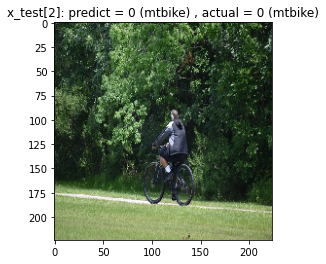

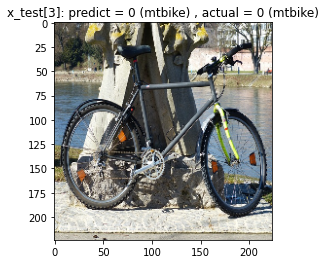

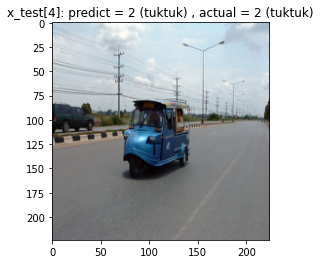

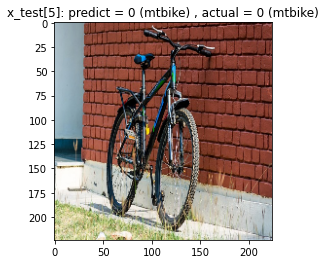

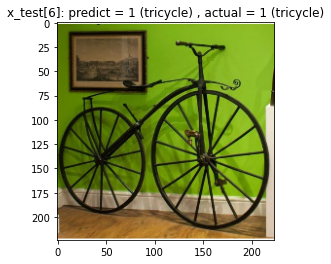

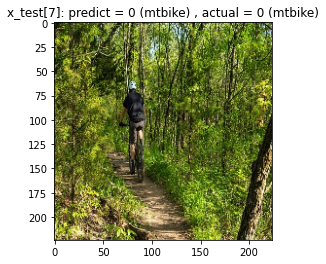

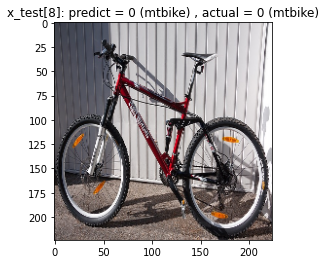

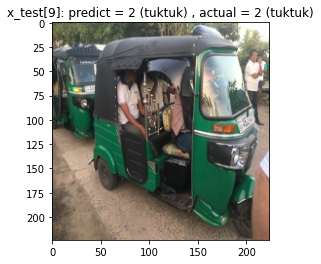

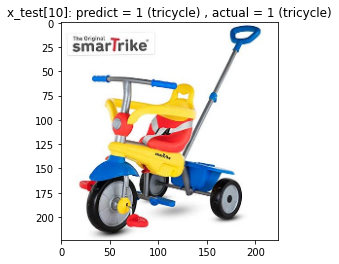

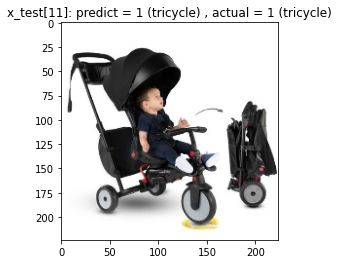

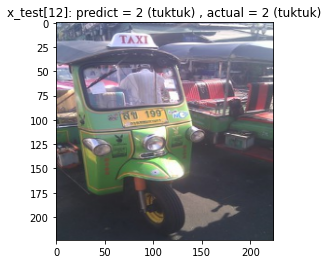

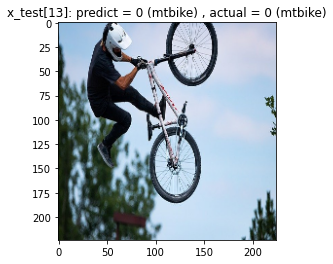

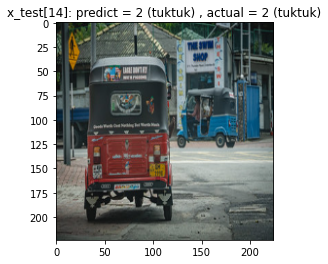

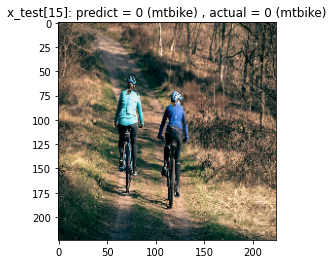

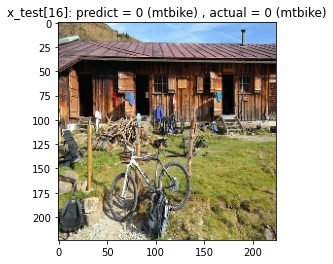

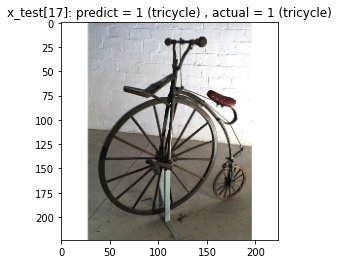

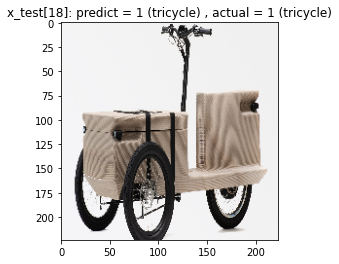

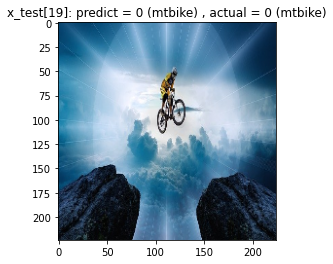

In [ ]:
#Test for first 20 images
for i in range(20):
  y_pred = model.predict(x_test_InceptionResNetV2[i].reshape(1, 224, 224, 3))

  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()